In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
from keras.preprocessing.text import text_to_word_sequence
from nltk.stem import PorterStemmer 
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.cm as cm
from matplotlib import rcParams
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
import re
import string
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [4]:
data = pd.read_csv("/content/gdrive/MyDrive/training.1600000.processed.noemoticon.csv", encoding = "ISO-8859-1")
data.columns = ['label', 'time', 'date', 'query', 'username', 'text']

In [5]:
data.head(10)

,label,time,date,query,username,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
5,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
6,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
7,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
8,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?
9,0,1467812416,Mon Apr 06 22:20:16 PDT 2009,NO_QUERY,erinx3leannexo,spring break in plain city... it's snowing


In [6]:
data.columns

Index(['label', 'time', 'date', 'query', 'username', 'text'], dtype='object')

In [7]:
print("the length of the data is", len(data))

the length of the data is 1599999


In [8]:
print(data.shape)

(1599999, 6)


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 6 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   label     1599999 non-null  int64 
 1   time      1599999 non-null  int64 
 2   date      1599999 non-null  object
 3   query     1599999 non-null  object
 4   username  1599999 non-null  object
 5   text      1599999 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [10]:
data.describe()

,label,time
count,1.599999e+06,1.599999e+06
mean,2.000001e+00,1.998818e+09
std,2.000001e+00,1.935757e+08
min,0.000000e+00,1.467811e+09
25%,0.000000e+00,1.956916e+09
50%,4.000000e+00,2.002102e+09
75%,4.000000e+00,2.177059e+09
max,4.000000e+00,2.329206e+09


In [11]:
data.isnull().sum()

label       0
time        0
date        0
query       0
username    0
text        0
dtype: int64

In [12]:
data.dtypes

label        int64
time         int64
date        object
query       object
username    object
text        object
dtype: object

In [13]:
print(data.label)

0          0
1          0
2          0
3          0
4          0
          ..
1599994    4
1599995    4
1599996    4
1599997    4
1599998    4
Name: label, Length: 1599999, dtype: int64


In [14]:
data = data[['text', 'label']]

In [15]:
data['label'][data['label']==4]=1

In [16]:
data_pos = data[data['label'] == 1]
data_neg = data[data['label'] == 0]

In [17]:
print(data_pos)

                                                      text  label
799999        I LOVE @Health4UandPets u guys r the best!!       1
800000   im meeting up with one of my besties tonight! ...      1
800001   @DaRealSunisaKim Thanks for the Twitter add, S...      1
800002   Being sick can be really cheap when it hurts t...      1
800003     @LovesBrooklyn2 he has that effect on everyone       1
...                                                    ...    ...
1599994  Just woke up. Having no school is the best fee...      1
1599995  TheWDB.com - Very cool to hear old Walt interv...      1
1599996  Are you ready for your MoJo Makeover? Ask me f...      1
1599997  Happy 38th Birthday to my boo of alll time!!! ...      1
1599998  happy #charitytuesday @theNSPCC @SparksCharity...      1

[800000 rows x 2 columns]


In [18]:
print(data_neg)

                                                     text  label
0       is upset that he can't update his Facebook by ...      0
1       @Kenichan I dived many times for the ball. Man...      0
2         my whole body feels itchy and like its on fire       0
3       @nationwideclass no, it's not behaving at all....      0
4                           @Kwesidei not the whole crew       0
...                                                   ...    ...
799994  Sick  Spending my day laying in bed listening ...      0
799995                                    Gmail is down?       0
799996                      rest in peace Farrah! So sad       0
799997  @Eric_Urbane Sounds like a rival is flagging y...      0
799998  has to resit exams over summer...  wishes he w...      0

[799999 rows x 2 columns]


In [19]:
data_pos = data_pos.iloc[:int(20000)]
data_neg = data_neg.iloc[:int(20000)]

In [20]:
data_combine = pd.concat([data_pos, data_neg])

In [21]:
data['text'] = data['text'].str.lower()

In [22]:
print(data['text'])

0          is upset that he can't update his facebook by ...
1          @kenichan i dived many times for the ball. man...
2            my whole body feels itchy and like its on fire 
3          @nationwideclass no, it's not behaving at all....
4                              @kwesidei not the whole crew 
                                 ...                        
1599994    just woke up. having no school is the best fee...
1599995    thewdb.com - very cool to hear old walt interv...
1599996    are you ready for your mojo makeover? ask me f...
1599997    happy 38th birthday to my boo of alll time!!! ...
1599998    happy #charitytuesday @thenspcc @sparkscharity...
Name: text, Length: 1599999, dtype: object


In [23]:
from nltk.corpus import stopwords

In [24]:
import nltk

In [25]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [26]:
stopwords_list = stopwords.words('english')

In [27]:
", ".join(stopwords.words('english'))

"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

In [28]:
STOPWORDS = set(stopwords.words('english'))
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
data['text'] = data['text'].apply(lambda text: cleaning_stopwords(text))
data['text'].head()

0    upset can't update facebook texting it... migh...
1    @kenichan dived many times ball. managed save ...
2                     whole body feels itchy like fire
3    @nationwideclass no, behaving all. i'm mad. he...
4                                 @kwesidei whole crew
Name: text, dtype: object

In [29]:
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

In [30]:
data['text']= data['text'].apply(lambda x: cleaning_punctuations(x))

In [31]:
print(data['text'])

0          upset cant update facebook texting it might cr...
1          kenichan dived many times ball managed save 50...
2                           whole body feels itchy like fire
3          nationwideclass no behaving all im mad here ca...
4                                        kwesidei whole crew
                                 ...                        
1599994                     woke up school best feeling ever
1599995    thewdbcom  cool hear old walt interviews â« h...
1599996                      ready mojo makeover ask details
1599997    happy 38th birthday boo alll time tupac amaru ...
1599998    happy charitytuesday thenspcc sparkscharity sp...
Name: text, Length: 1599999, dtype: object


In [32]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)

In [33]:
data['text']= data['text'].apply(lambda x: cleaning_repeating_char(x))

In [34]:
print(data['text'])

0          upset cant update facebok texting it might cry...
1          kenichan dived many times bal managed save 50 ...
2                            whole body fels itchy like fire
3          nationwideclas no behaving al im mad here cant...
4                                        kwesidei whole crew
                                 ...                        
1599994                       woke up schol best feling ever
1599995    thewdbcom col hear old walt interviews â« htp...
1599996                      ready mojo makeover ask details
1599997     hapy 38th birthday bo al time tupac amaru shakur
1599998    hapy charitytuesday thenspc sparkscharity spea...
Name: text, Length: 1599999, dtype: object


In [35]:
def cleaning_email(data):
    return re.sub('@[^\s]+', ' ', data)

In [36]:
data['text']= data['text'].apply(lambda x: cleaning_email(x))

In [37]:
print(data['text'])

0          upset cant update facebok texting it might cry...
1          kenichan dived many times bal managed save 50 ...
2                            whole body fels itchy like fire
3          nationwideclas no behaving al im mad here cant...
4                                        kwesidei whole crew
                                 ...                        
1599994                       woke up schol best feling ever
1599995    thewdbcom col hear old walt interviews â« htp...
1599996                      ready mojo makeover ask details
1599997     hapy 38th birthday bo al time tupac amaru shakur
1599998    hapy charitytuesday thenspc sparkscharity spea...
Name: text, Length: 1599999, dtype: object


In [38]:
def cleaning_URLs(data):
    return re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',data)

In [39]:
data['text']= data['text'].apply(lambda x: cleaning_URLs(x))

In [40]:
print(data['text'])

0          upset cant update facebok texting it might cry...
1          kenichan dived many times bal managed save 50 ...
2                            whole body fels itchy like fire
3          nationwideclas no behaving al im mad here cant...
4                                        kwesidei whole crew
                                 ...                        
1599994                       woke up schol best feling ever
1599995    thewdbcom col hear old walt interviews â« htp...
1599996                      ready mojo makeover ask details
1599997     hapy 38th birthday bo al time tupac amaru shakur
1599998    hapy charitytuesday thenspc sparkscharity spea...
Name: text, Length: 1599999, dtype: object


In [41]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)


In [42]:
data['text']= data['text'].apply(lambda x: cleaning_numbers(x))

In [43]:
print(data['text'])

0          upset cant update facebok texting it might cry...
1          kenichan dived many times bal managed save  re...
2                            whole body fels itchy like fire
3          nationwideclas no behaving al im mad here cant...
4                                        kwesidei whole crew
                                 ...                        
1599994                       woke up schol best feling ever
1599995    thewdbcom col hear old walt interviews â« htp...
1599996                      ready mojo makeover ask details
1599997       hapy th birthday bo al time tupac amaru shakur
1599998    hapy charitytuesday thenspc sparkscharity spea...
Name: text, Length: 1599999, dtype: object


In [44]:
tokenizer = RegexpTokenizer(r'\w+')
data['text'] = data['text'].apply(tokenizer.tokenize)


In [45]:
data['text'].head()

0    [upset, cant, update, facebok, texting, it, mi...
1    [kenichan, dived, many, times, bal, managed, s...
2               [whole, body, fels, itchy, like, fire]
3    [nationwideclas, no, behaving, al, im, mad, he...
4                              [kwesidei, whole, crew]
Name: text, dtype: object

In [46]:
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data

data['text']= data['text'].apply(lambda x: stemming_on_text(x))

In [47]:
data['text'].head()

0    [upset, cant, update, facebok, texting, it, mi...
1    [kenichan, dived, many, times, bal, managed, s...
2               [whole, body, fels, itchy, like, fire]
3    [nationwideclas, no, behaving, al, im, mad, he...
4                              [kwesidei, whole, crew]
Name: text, dtype: object

In [48]:

import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [49]:
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data

data['text'] = data['text'].apply(lambda x: lemmatizer_on_text(x))


In [50]:
data['text'].head()

0    [upset, cant, update, facebok, texting, it, mi...
1    [kenichan, dived, many, times, bal, managed, s...
2               [whole, body, fels, itchy, like, fire]
3    [nationwideclas, no, behaving, al, im, mad, he...
4                              [kwesidei, whole, crew]
Name: text, dtype: object

In [51]:
X = data['text']
print(X)

0          [upset, cant, update, facebok, texting, it, mi...
1          [kenichan, dived, many, times, bal, managed, s...
2                     [whole, body, fels, itchy, like, fire]
3          [nationwideclas, no, behaving, al, im, mad, he...
4                                    [kwesidei, whole, crew]
                                 ...                        
1599994                [woke, up, schol, best, feling, ever]
1599995    [thewdbcom, col, hear, old, walt, interviews, ...
1599996                [ready, mojo, makeover, ask, details]
1599997    [hapy, th, birthday, bo, al, time, tupac, amar...
1599998    [hapy, charitytuesday, thenspc, sparkscharity,...
Name: text, Length: 1599999, dtype: object


In [52]:
Y = data['label']
print(Y)

0          0
1          0
2          0
3          0
4          0
          ..
1599994    1
1599995    1
1599996    1
1599997    1
1599998    1
Name: label, Length: 1599999, dtype: int64


In [53]:
max_len = 500
tok = Tokenizer(num_words=2000)
tok.fit_on_texts(X)
sequences = tok.texts_to_sequences(X)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)
sequences_matrix.shape

(1599999, 500)

In [54]:
X_train, X_test, Y_train, Y_test = train_test_split(sequences_matrix, Y, test_size = 0.3, random_state = 42)

In [55]:
def tf_based_model():
  inputs = Input(name='inputs',shape=[max_len])
  layer = Embedding(2000,50,input_length=max_len)(inputs) 
  layer = LSTM(64)(layer) 
  layer = Dense(256,name='FC1')(layer) 
  layer = Activation('relu')(layer) 
  layer = Dropout(0.5)(layer)
  layer = Dense(1,name='out_layer')(layer)
  layer = Activation('sigmoid')(layer)
  model = Model(inputs=inputs,outputs=layer)
  return model 

In [56]:
model = tf_based_model()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])  

In [58]:
history=model.fit(X_train,Y_train,batch_size=80,epochs=4, validation_split=0.1)


Epoch 1/4
12600/12600 [==============================] - 5477s 435ms/step - loss: 0.4790 - accuracy: 0.7698 - val_loss: 0.4742 - val_accuracy: 0.7697
Epoch 2/4
12600/12600 [==============================] - 5493s 436ms/step - loss: 0.5625 - accuracy: 0.7644 - val_loss: 0.4904 - val_accuracy: 0.7624
Epoch 3/4
12600/12600 [==============================] - 5510s 437ms/step - loss: 0.5086 - accuracy: 0.7657 - val_loss: 0.4863 - val_accuracy: 0.7683
Epoch 4/4
12600/12600 [==============================] - 5566s 442ms/step - loss: 0.4865 - accuracy: 0.7689 - val_loss: 0.4801 - val_accuracy: 0.7688


In [ ]:
accr1 = model.evaluate(X_test,Y_test)


15000/15000 [==============================] - 799s 53ms/step - loss: 0.6930 - accuracy: 0.5039


In [ ]:
print('Test set\n  Accuracy: {:0.2f}'.format(accr1[1]))


Test set
  Accuracy: 0.50


In [ ]:
y_pred = model.predict(X_test) #getting predictions on the trained model
y_pred = (y_pred > 0.5) 



confusion matrix


[[ 54088 185273]
 [ 51884 188755]]




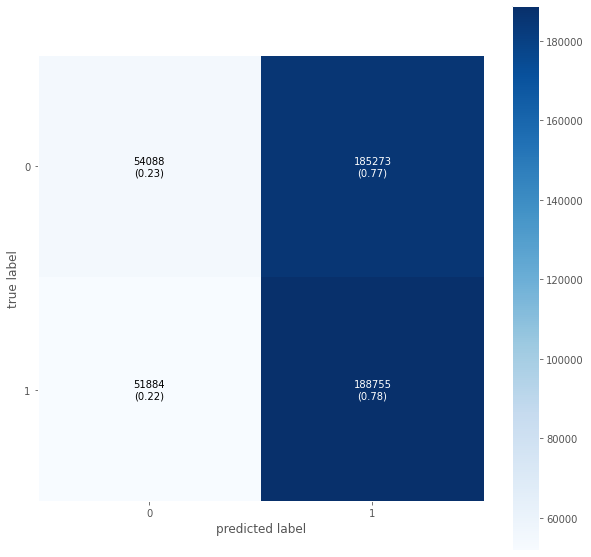

In [ ]:
print('\n')
print("confusion matrix")
print('\n')
CR=confusion_matrix(Y_test, y_pred)
print(CR)
print('\n')

fig, ax = plot_confusion_matrix(conf_mat=CR,figsize=(10, 10),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()


In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

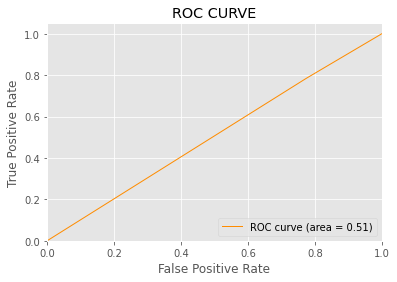

In [ ]:
fpr, tpr, thresholds = roc_curve(Y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()